# 08: Some Final Modeling

### Imported Libraries

In [1]:
import sys
print('Python version: %s' % (sys.version))
from collections import Counter
print('\tCounter imported.')

# data management
print('\nData Management Libraries')
import pandas as pd
print('\tpandas version: %s' % (pd.__version__))
import numpy as np
print('\tnumpy version: %s' % (np.__version__))
import regex as re
print('\tregex version: %s' % (re.__version__))

# visualizing
print('\nVisualization Libraries')
from matplotlib import pyplot as plt
import matplotlib
print('\tmatplotlib version: %s' % (matplotlib.__version__))
import seaborn as sns
print('\tseaborn version: %s' % (sns.__version__))

# modeling
print('\nModeling Libraries')
import imblearn
print('\timblearn version: %s' % imblearn.__version__)
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import sklearn
print('\tsklearn version: %s' % sklearn.__version__)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

Python version: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
	Counter imported.

Data Management Libraries
	pandas version: 1.2.3
	numpy version: 1.19.2
	regex version: 2.5.91

Visualization Libraries
	matplotlib version: 3.3.4
	seaborn version: 0.11.1

Modeling Libraries
	imblearn version: 0.8.0
	sklearn version: 0.24.1


### Update Library Settings

In [2]:
# set random state for reproducibility
random_state = 42

# default numpy settings
np.set_printoptions(edgeitems=3)
np.core.arrayprint._line_width = 80

# update settings
np.set_printoptions(edgeitems=15, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

# update pandas settings
pd.options.display.max_columns = 20
pd.set_option('max_colwidth', 100) # sets the max number of columns before truncating with an ellipse
pd.options.display.max_rows = 500
pd.set_option('precision',6)

### Helper Functions

In [3]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy\t= %.2f" % (accuracy_score(y_actual, y_predicted)))
    print("Precision\t= %.2f" % (precision_score(y_actual, y_predicted)))
    print("Recall\t\t= %.2f" % (recall_score(y_actual, y_predicted)))
    print("F1 Score\t= %.2f" % (f1_score(y_actual, y_predicted)))
    pass
    
def plot_feature_correlation_heatmap(df,title,xsize,ysize):
    fig, ax = plt.subplots(1,1,figsize=(xsize,ysize))
    corr=df.corr()
    sns.heatmap(corr,cmap='coolwarm_r',annot_kws={'size':20},ax=ax)
    ax.set_title(title,fontsize=14)
    plt.show()
    
def plot_cmat_prc_roc(clf,X_test,y_test,title):
    fig, ax = plt.subplots(1,3,figsize=(16,4.5))
    fig.suptitle(title,fontsize=14)
    plot_confusion_matrix(clf,X_test,y_test,ax=ax[0],cmap='Greys',colorbar=False) 
    ax[0].set_title('Confusion Matrix')
    plot_roc_curve(clf,X_test,y_test,ax=ax[1])
    ax[1].set_title('ROC Curve')
    plot_precision_recall_curve(clf,X_test,y_test,ax=ax[2])
    ax[2].set_title('Precision-Recall Curve')
    plt.show()

### Import Dataframe

In [4]:
df = pd.read_csv('../data/creditcard_03_notScaled.csv')

In [5]:
df.shape

(284807, 31)

In [6]:
df.head()

,Time_DayAware,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.0,149.62,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,0.0,2.69,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.0,378.66,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.0,123.50,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,2.0,69.99,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [7]:
df.describe()

,Time_DayAware,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,52336.622709,88.349619,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,...,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,0.001727
std,21049.420490,250.120109,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,0.000000,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,38153.500000,5.600000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,54039.000000,22.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,69587.000000,77.165000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,86398.000000,25691.160000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


##### Create Independent, Dependent Variable DataFrames

In [8]:
X = df.drop('Class', axis=1)     # drop the output series from the dataset to isolate inputs (independent features)
y = df['Class']     # set y to the output series (dependent feature)

##### Split into train, test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=random_state)     # setting training size of dataset to 70%

### Oversampling with Smote, Random Forest Classifier

In [10]:
sm = SMOTE(random_state=random_state)
smX_train,smy_train = sm.fit_resample(X_train,y_train)
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(smy_train))

Before fit: Counter({0: 199008, 1: 356})
After fit: Counter({0: 199008, 1: 199008})


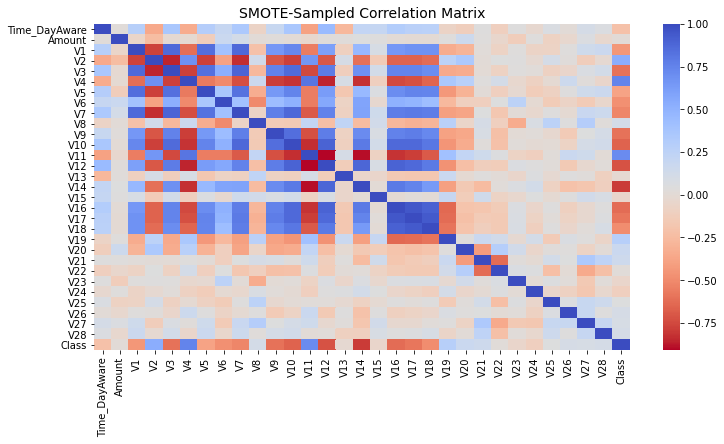

In [11]:
smote_df = smX_train.copy()
smote_df['Class'] = smy_train.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,6)

In [12]:
%%time
clf = RandomForestClassifier(random_state=random_state,n_jobs=-1)     # instantiate random forest classifier class object
clf.fit(smX_train,smy_train) # fit model

Wall time: 52.2 s


RandomForestClassifier(n_jobs=-1, random_state=42)


[[85286    21]
 [   18   118]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.85      0.87      0.86       136

    accuracy                           1.00     85443
   macro avg       0.92      0.93      0.93     85443
weighted avg       1.00      1.00      1.00     85443




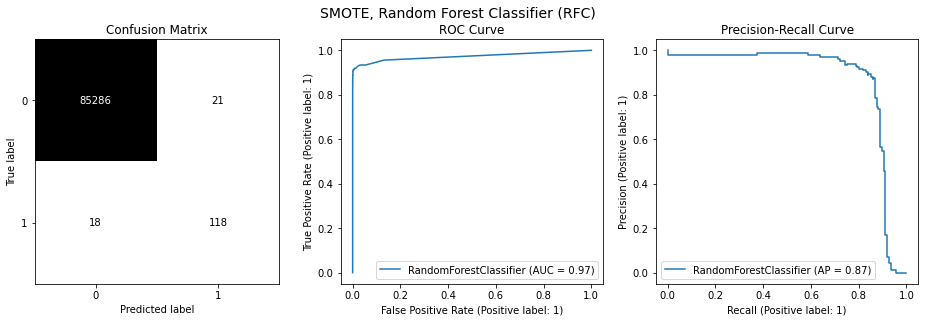

Accuracy	= 1.00
Precision	= 0.85
Recall		= 0.87
F1 Score	= 0.86



In [13]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test, 'SMOTE, Random Forest Classifier (RFC)')
generate_model_report(y_test,y_pred)
print()

### Select Top 50% MDI Features

##### Subselect top 50% from MDI Feature Importance

In [14]:
#top_half_Mdi = ['V14', 'V10', 'V12', 'V4', 'V17', 'V11', 'V3', 'V16', 'V7', 'V9', 'V2', 'V1', 'V6', 'V27', 'Time_DayAware'] # list of top features from MDI
top_half_Mdi = ['V14', 'V10', 'V12', 'V4', 'V17', 'V11', 'V3', 'V16', 'V7', 'V9', 'V2', 'V18', 'V6', 'V21', 'Time_DayAware'] # list of top features from MDI
X_Mdi = X.loc[:,top_half_Mdi]
X_Mdi.head()

,V14,V10,V12,V4,V17,V11,V3,V16,V7,V9,V2,V18,V6,V21,Time_DayAware
0,-0.311169,0.090794,-0.617801,1.378155,0.207971,-0.551600,2.536347,-0.470401,0.239599,0.363787,-0.072781,0.025791,0.462388,-0.018307,0.0
1,-0.143772,-0.166974,1.065235,0.448154,-0.114805,1.612727,0.166480,0.463917,-0.078803,-0.255425,0.266151,-0.183361,-0.082361,-0.225775,0.0
2,-0.165946,0.207643,0.066084,0.379780,1.109969,0.624501,1.773209,-2.890083,0.791461,-1.514654,-1.340163,-0.121359,1.800499,0.247998,1.0
3,-0.287924,-0.054952,0.178228,-0.863291,-0.684093,-0.226487,1.792993,-1.059647,0.237609,-1.387024,-0.185226,1.965775,1.247203,-0.108300,1.0
4,-1.119670,0.753074,0.538196,0.403034,-0.237033,-0.822843,1.548718,-0.451449,0.592941,0.817739,0.877737,-0.038195,0.095921,-0.009431,2.0


Before fit: Counter({0: 199008, 1: 356})
After fit: Counter({0: 199008, 1: 199008})


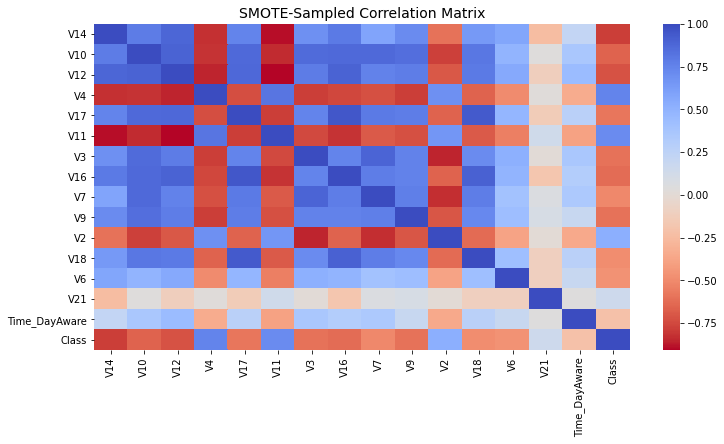

In [15]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_Mdi,y,train_size=0.7,random_state=random_state)     # setting training size of dataset to 70%

# Synthetic Sample
sm = SMOTE(random_state=random_state)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

# printout counts
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(y_train_sm))

smote_df = X_train_sm.copy()
smote_df['Class'] = y_train_sm.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,6)

In [16]:
%%time
clf = RandomForestClassifier(random_state=random_state,n_jobs=-1)     # instantiate random forest classifier class object
clf.fit(X_train_sm,y_train_sm) # fit model

Wall time: 30.1 s


RandomForestClassifier(n_jobs=-1, random_state=42)


[[85282    25]
 [   16   120]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.83      0.88      0.85       136

    accuracy                           1.00     85443
   macro avg       0.91      0.94      0.93     85443
weighted avg       1.00      1.00      1.00     85443




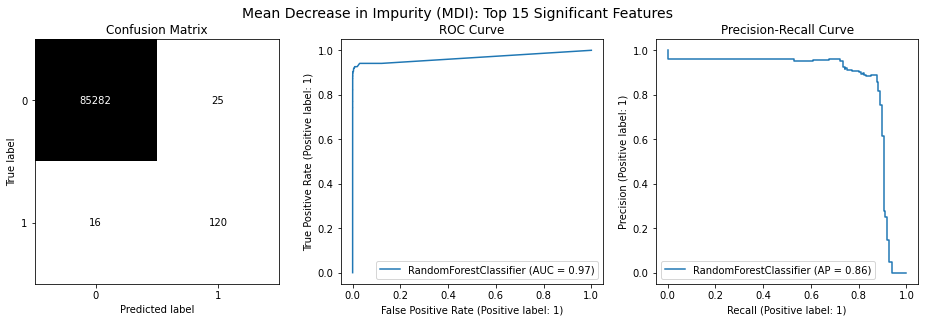

Accuracy	= 1.00
Precision	= 0.83
Recall		= 0.88
F1 Score	= 0.85



In [17]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test,'Mean Decrease in Impurity (MDI): Top 15 Significant Features')
generate_model_report(y_test,y_pred)
print()

### Top 15 MDI post-Smote

In [18]:
#top_half_Mdi = ['V14', 'V10', 'V12', 'V4', 'V17', 'V11', 'V3', 'V16', 'V7', 'V9', 'V2', 'V1', 'V6', 'V27', 'Time_DayAware'] # list of top features from MDI
top_half_Mdi = ['V14', 'V10', 'V12', 'V4', 'V17', 'V11', 'V3', 'V16', 'V7', 'V9', 'V2', 'V18', 'V6', 'V21', 'Time_DayAware'] # list of top features from MDI
X_Mdi = X.loc[:,top_half_Mdi]
X_Mdi.head()

,V14,V10,V12,V4,V17,V11,V3,V16,V7,V9,V2,V18,V6,V21,Time_DayAware
0,-0.311169,0.090794,-0.617801,1.378155,0.207971,-0.551600,2.536347,-0.470401,0.239599,0.363787,-0.072781,0.025791,0.462388,-0.018307,0.0
1,-0.143772,-0.166974,1.065235,0.448154,-0.114805,1.612727,0.166480,0.463917,-0.078803,-0.255425,0.266151,-0.183361,-0.082361,-0.225775,0.0
2,-0.165946,0.207643,0.066084,0.379780,1.109969,0.624501,1.773209,-2.890083,0.791461,-1.514654,-1.340163,-0.121359,1.800499,0.247998,1.0
3,-0.287924,-0.054952,0.178228,-0.863291,-0.684093,-0.226487,1.792993,-1.059647,0.237609,-1.387024,-0.185226,1.965775,1.247203,-0.108300,1.0
4,-1.119670,0.753074,0.538196,0.403034,-0.237033,-0.822843,1.548718,-0.451449,0.592941,0.817739,0.877737,-0.038195,0.095921,-0.009431,2.0


Before fit: Counter({0: 199008, 1: 356})
After fit: Counter({0: 199008, 1: 199008})


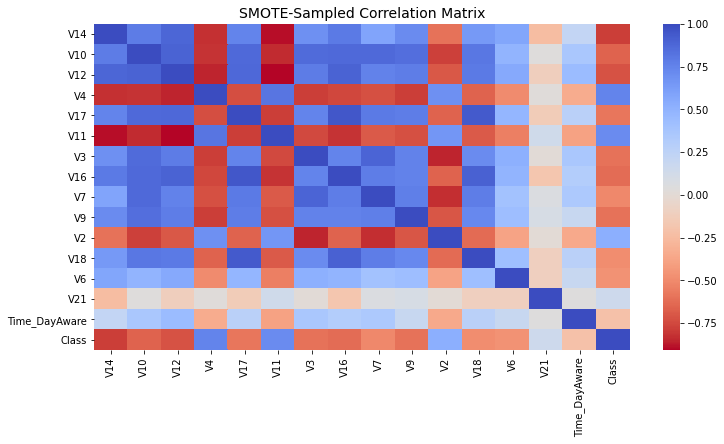

In [19]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_Mdi,y,train_size=0.7,random_state=random_state)     # setting training size of dataset to 70%

# Synthetic Sample
sm = SMOTE(random_state=random_state)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

# printout counts
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(y_train_sm))

smote_df = X_train_sm.copy()
smote_df['Class'] = y_train_sm.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,6)

In [20]:
%%time
clf = RandomForestClassifier(random_state=random_state,n_jobs=-1)     # instantiate random forest classifier class object
clf.fit(X_train_sm,y_train_sm) # fit model

Wall time: 30.3 s


RandomForestClassifier(n_jobs=-1, random_state=42)


[[85282    25]
 [   16   120]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.83      0.88      0.85       136

    accuracy                           1.00     85443
   macro avg       0.91      0.94      0.93     85443
weighted avg       1.00      1.00      1.00     85443




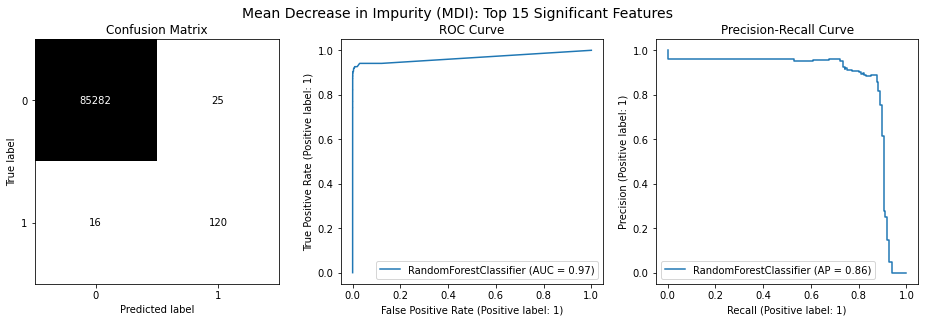

Accuracy	= 1.00
Precision	= 0.83
Recall		= 0.88
F1 Score	= 0.85



In [21]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test,'Mean Decrease in Impurity (MDI): Top 15 Significant Features')
generate_model_report(y_test,y_pred)
print()

### Model with Top Permutation Importance Features

In [22]:
top_half_Pi = ['V12','V4','V3','V14','V10','V27','V11','V17','V16','V28','V7','V26','V20','V25'] # list of top features from MDI

X_Pi = X.loc[:,top_half_Pi]
X_Pi.head()

,V12,V4,V3,V14,V10,V27,V11,V17,V16,V28,V7,V26,V20,V25
0,-0.617801,1.378155,2.536347,-0.311169,0.090794,0.133558,-0.551600,0.207971,-0.470401,-0.021053,0.239599,-0.189115,0.251412,0.128539
1,1.065235,0.448154,0.166480,-0.143772,-0.166974,-0.008983,1.612727,-0.114805,0.463917,0.014724,-0.078803,0.125895,-0.069083,0.167170
2,0.066084,0.379780,1.773209,-0.165946,0.207643,-0.055353,0.624501,1.109969,-2.890083,-0.059752,0.791461,-0.139097,0.524980,-0.327642
3,0.178228,-0.863291,1.792993,-0.287924,-0.054952,0.062723,-0.226487,-0.684093,-1.059647,0.061458,0.237609,-0.221929,-0.208038,0.647376
4,0.538196,0.403034,1.548718,-1.119670,0.753074,0.219422,-0.822843,-0.237033,-0.451449,0.215153,0.592941,0.502292,0.408542,-0.206010


Before fit: Counter({0: 199008, 1: 356})
After fit: Counter({0: 199008, 1: 199008})


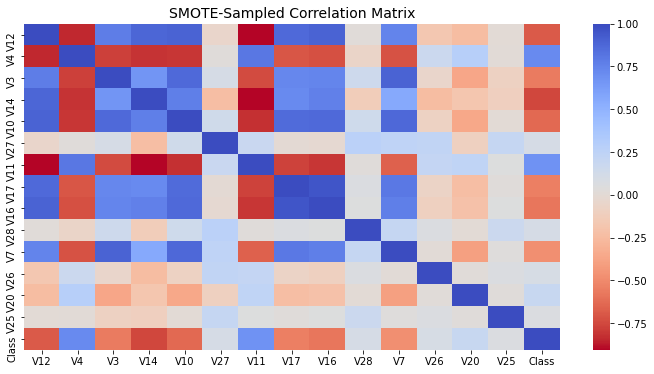

In [23]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_Pi,y,train_size=0.7,random_state=random_state)     # setting training size of dataset to 70%

# Synthetic Sample
sm = SMOTE(random_state=random_state)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

# printout counts
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(y_train_sm))

smote_df = X_train_sm.copy()
smote_df['Class'] = y_train_sm.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,6)

In [24]:
%%time
clf = RandomForestClassifier(random_state=random_state,n_jobs=-1)     # instantiate random forest classifier class object
clf.fit(X_train_sm,y_train_sm) # fit model

Wall time: 29.2 s


RandomForestClassifier(n_jobs=-1, random_state=42)


[[85278    29]
 [   17   119]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.80      0.88      0.84       136

    accuracy                           1.00     85443
   macro avg       0.90      0.94      0.92     85443
weighted avg       1.00      1.00      1.00     85443




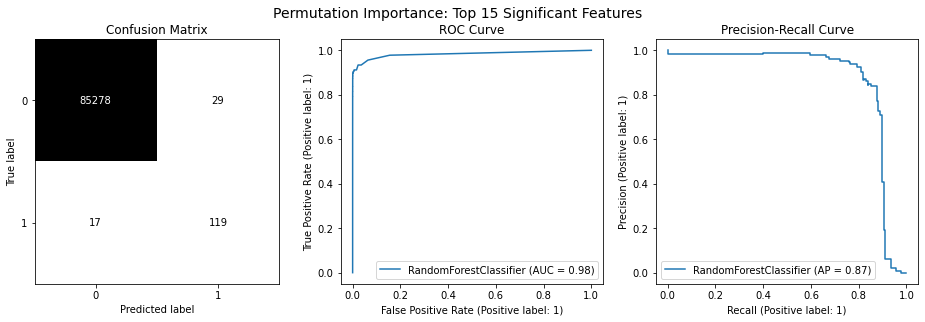

Accuracy	= 1.00
Precision	= 0.80
Recall		= 0.88
F1 Score	= 0.84



In [25]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test,'Permutation Importance: Top 15 Significant Features')
generate_model_report(y_test,y_pred)
print()

### Model with Combined Top 12

In [45]:
top_twelve = ['Time_DayAware', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V3', 'V4', 'V8', 'V7','V1','V21'] # combines significant features from smote MDI, no resample MDI, Permutation Importance

X_top_twelve = X.loc[:,top_twelve]
X_top_twelve.head()

,Time_DayAware,V10,V11,V12,V14,V16,V17,V3,V4,V8,V7,V1,V21
0,0.0,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,2.536347,1.378155,0.098698,0.239599,-1.359807,-0.018307
1,0.0,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,0.166480,0.448154,0.085102,-0.078803,1.191857,-0.225775
2,1.0,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,1.773209,0.379780,0.247676,0.791461,-1.358354,0.247998
3,1.0,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.792993,-0.863291,0.377436,0.237609,-0.966272,-0.108300
4,2.0,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,1.548718,0.403034,-0.270533,0.592941,-1.158233,-0.009431


Before fit: Counter({0: 199008, 1: 356})
After fit: Counter({0: 199008, 1: 199008})


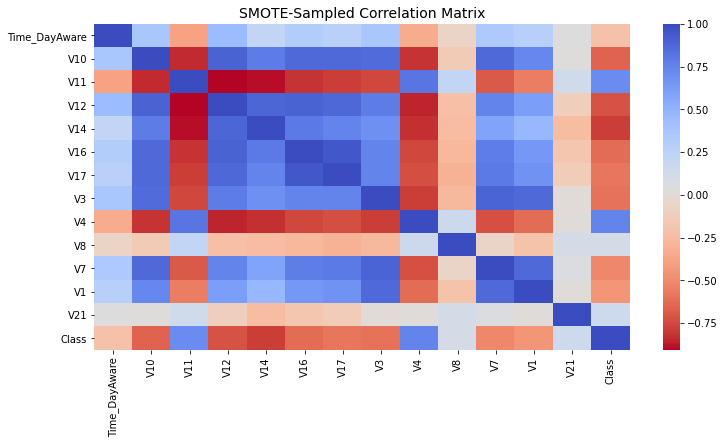

In [46]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_top_twelve,y,train_size=0.7,random_state=random_state)     # setting training size of dataset to 70%

# Synthetic Sample
sm = SMOTE(random_state=random_state)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

# printout counts
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(y_train_sm))

smote_df = X_train_sm.copy()
smote_df['Class'] = y_train_sm.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,6)

In [47]:
%%time
clf = RandomForestClassifier(random_state=random_state,n_jobs=-1)     # instantiate random forest classifier class object
clf.fit(X_train_sm,y_train_sm) # fit model

Wall time: 30.1 s


RandomForestClassifier(n_jobs=-1, random_state=42)


[[85279    28]
 [   15   121]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.81      0.89      0.85       136

    accuracy                           1.00     85443
   macro avg       0.91      0.94      0.92     85443
weighted avg       1.00      1.00      1.00     85443




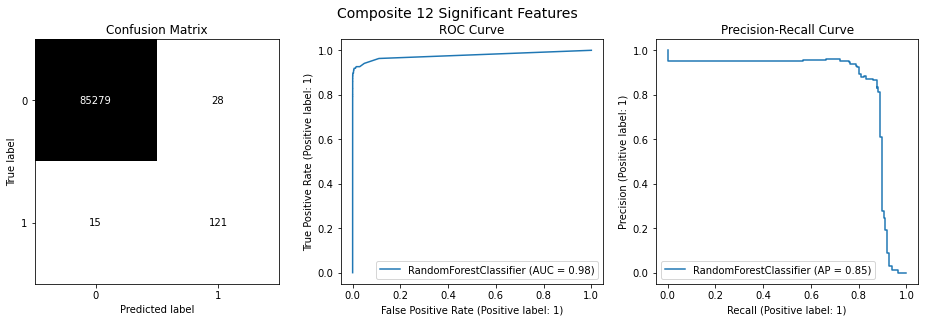

Accuracy	= 1.00
Precision	= 0.81
Recall		= 0.89
F1 Score	= 0.85



In [48]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test,'Composite 12 Significant Features')
generate_model_report(y_test,y_pred)
print()

### Model with Combined Top 8

In [49]:
top_eight = ['V17','V12','V14','V10','V4','V3','V27','V11'] # combines significant features from smote MDI, no resample MDI, Permutation Importance

X_top_eight = X.loc[:,top_eight]
X_top_eight.head()

,V17,V12,V14,V10,V4,V3,V27,V11
0,0.207971,-0.617801,-0.311169,0.090794,1.378155,2.536347,0.133558,-0.551600
1,-0.114805,1.065235,-0.143772,-0.166974,0.448154,0.166480,-0.008983,1.612727
2,1.109969,0.066084,-0.165946,0.207643,0.379780,1.773209,-0.055353,0.624501
3,-0.684093,0.178228,-0.287924,-0.054952,-0.863291,1.792993,0.062723,-0.226487
4,-0.237033,0.538196,-1.119670,0.753074,0.403034,1.548718,0.219422,-0.822843


Before fit: Counter({0: 199008, 1: 356})
After fit: Counter({0: 199008, 1: 199008})


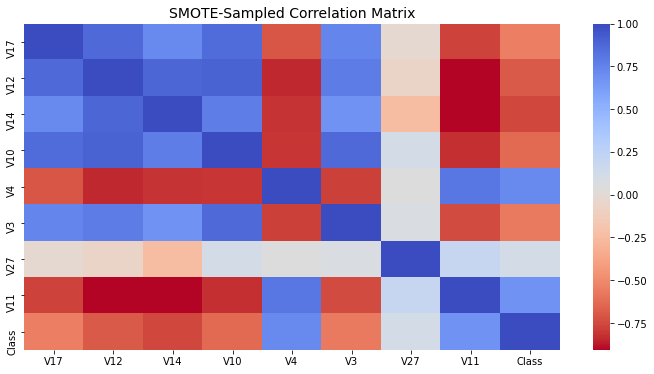

In [50]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_top_eight,y,train_size=0.7,random_state=random_state)     # setting training size of dataset to 70%

# Synthetic Sample
sm = SMOTE(random_state=random_state)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

# printout counts
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(y_train_sm))

smote_df = X_train_sm.copy()
smote_df['Class'] = y_train_sm.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,6)

In [51]:
%%time
clf = RandomForestClassifier(random_state=random_state,n_jobs=-1)     # instantiate random forest classifier class object
clf.fit(X_train_sm,y_train_sm) # fit model

Wall time: 21.7 s


RandomForestClassifier(n_jobs=-1, random_state=42)


[[85259    48]
 [   19   117]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.71      0.86      0.78       136

    accuracy                           1.00     85443
   macro avg       0.85      0.93      0.89     85443
weighted avg       1.00      1.00      1.00     85443




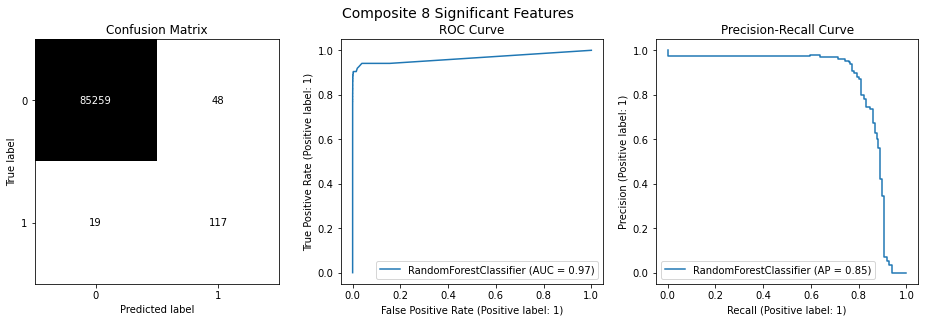

Accuracy	= 1.00
Precision	= 0.71
Recall		= 0.86
F1 Score	= 0.78



In [52]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test,'Composite 8 Significant Features')
generate_model_report(y_test,y_pred)
print()

### Model with Combined Top 3

In [53]:
top_three = ['V14','V12','V17'] # combines significant features from smote MDI, no resample MDI, Permutation Importance

X_top_three = X.loc[:,top_three]
X_top_three.head()

,V14,V12,V17
0,-0.311169,-0.617801,0.207971
1,-0.143772,1.065235,-0.114805
2,-0.165946,0.066084,1.109969
3,-0.287924,0.178228,-0.684093
4,-1.119670,0.538196,-0.237033


Before fit: Counter({0: 199008, 1: 356})
After fit: Counter({0: 199008, 1: 199008})


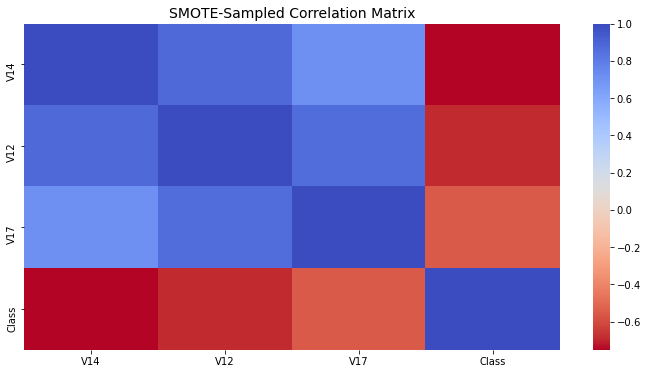

In [54]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_top_three,y,train_size=0.7,random_state=random_state)     # setting training size of dataset to 70%

# Synthetic Sample
sm = SMOTE(random_state=random_state)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

# printout counts
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(y_train_sm))

smote_df = X_train_sm.copy()
smote_df['Class'] = y_train_sm.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,6)

In [55]:
%%time
clf = RandomForestClassifier(random_state=random_state,n_jobs=-1)     # instantiate random forest classifier class object
clf.fit(X_train_sm,y_train_sm) # fit model

Wall time: 14 s


RandomForestClassifier(n_jobs=-1, random_state=42)


[[84675   632]
 [   18   118]]

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85307
           1       0.16      0.87      0.27       136

    accuracy                           0.99     85443
   macro avg       0.58      0.93      0.63     85443
weighted avg       1.00      0.99      1.00     85443




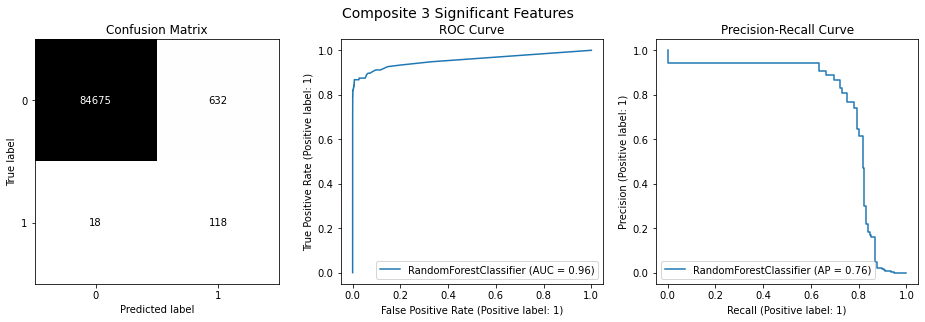

Accuracy	= 0.99
Precision	= 0.16
Recall		= 0.87
F1 Score	= 0.27



In [56]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test,'Composite 3 Significant Features')
generate_model_report(y_test,y_pred)
print()

### Model with Insignificant Bottom Half

In [57]:
bottom_half = ['V24','V23','V22','V25','V13','V8','V28','Time_DayAware','V5','Amount','V27','V15','V20','V26','V1'] # combines significant features from smote MDI, no resample MDI, Permutation Importance

X_bottom_half = X.loc[:,bottom_half]
X_bottom_half.head()

,V24,V23,V22,V25,V13,V8,V28,Time_DayAware,V5,Amount,V27,V15,V20,V26,V1
0,0.066928,-0.110474,0.277838,0.128539,-0.991390,0.098698,-0.021053,0.0,-0.338321,149.62,0.133558,1.468177,0.251412,-0.189115,-1.359807
1,-0.339846,0.101288,-0.638672,0.167170,0.489095,0.085102,0.014724,0.0,0.060018,2.69,-0.008983,0.635558,-0.069083,0.125895,1.191857
2,-0.689281,0.909412,0.771679,-0.327642,0.717293,0.247676,-0.059752,1.0,-0.503198,378.66,-0.055353,2.345865,0.524980,-0.139097,-1.358354
3,-1.175575,-0.190321,0.005274,0.647376,0.507757,0.377436,0.061458,1.0,-0.010309,123.50,0.062723,-0.631418,-0.208038,-0.221929,-0.966272
4,0.141267,-0.137458,0.798278,-0.206010,1.345852,-0.270533,0.215153,2.0,-0.407193,69.99,0.219422,0.175121,0.408542,0.502292,-1.158233


Before fit: Counter({0: 199008, 1: 356})
After fit: Counter({0: 199008, 1: 199008})


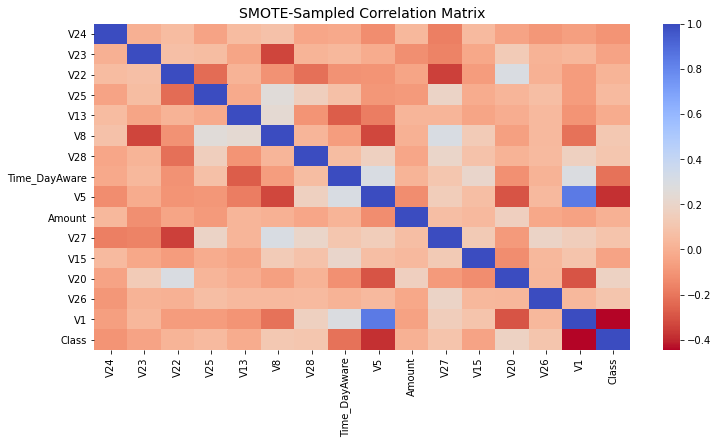

In [58]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_bottom_half,y,train_size=0.7,random_state=random_state)     # setting training size of dataset to 70%

# Synthetic Sample
sm = SMOTE(random_state=random_state)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

# printout counts
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(y_train_sm))

smote_df = X_train_sm.copy()
smote_df['Class'] = y_train_sm.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,6)

In [59]:
%%time
clf = RandomForestClassifier(random_state=random_state,n_jobs=-1)     # instantiate random forest classifier class object
clf.fit(X_train_sm,y_train_sm) # fit model

Wall time: 37.9 s


RandomForestClassifier(n_jobs=-1, random_state=42)


[[85273    34]
 [   63    73]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.68      0.54      0.60       136

    accuracy                           1.00     85443
   macro avg       0.84      0.77      0.80     85443
weighted avg       1.00      1.00      1.00     85443




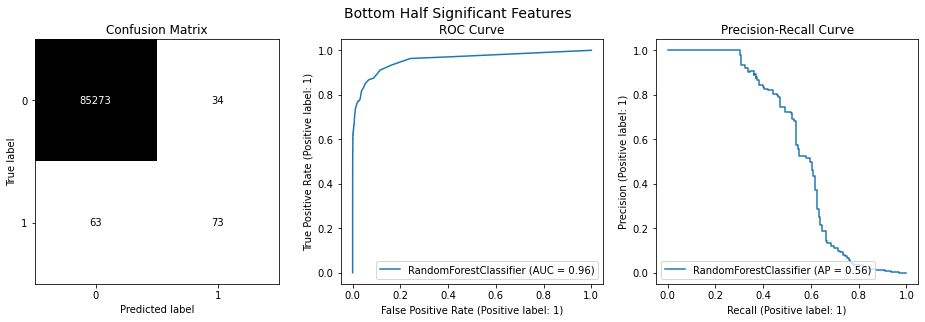

Accuracy	= 1.00
Precision	= 0.68
Recall		= 0.54
F1 Score	= 0.60



In [60]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test,'Bottom Half Significant Features')
generate_model_report(y_test,y_pred)
print()